In [98]:
%pip install pandas
%pip install requests


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [159]:
# DOWNLOAD THE DATASET

import pandas as pd

df = pd.read_csv("https://ourworldindata.org/grapher/annual-co2-emissions-per-country.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})

In [160]:
df.head()

,Entity,Code,Year,emissions_total
0,Afghanistan,AFG,1949,14656.0
1,Afghanistan,AFG,1950,84272.0
2,Afghanistan,AFG,1951,91600.0
3,Afghanistan,AFG,1952,91600.0
4,Afghanistan,AFG,1953,106256.0


In [161]:
# CHECK FOR MISSING VALUES 

missing_values = df.isnull().sum()
missing_values

Entity                0
Code               5640
Year                  0
emissions_total       0
dtype: int64

In [162]:
# CHECK THE SEMANTICS OF THE 'Code' column
# Turns out 'Code' is a country code, which means we can utilize this to filter out any data that is not for a single country (e.g. remove 'Wolrd' and continent-wise data)

empty_code_rows = df[df['Code'].isnull()]

print(empty_code_rows)

                              Entity Code  Year  emissions_total
75                            Africa  NaN  1884     2.198400e+04
76                            Africa  NaN  1885     3.664000e+04
77                            Africa  NaN  1886     4.763200e+04
78                            Africa  NaN  1887     4.763200e+04
79                            Africa  NaN  1888     8.060800e+04
...                              ...  ...   ...              ...
27867  Upper-middle-income countries  NaN  2019     1.635260e+10
27868  Upper-middle-income countries  NaN  2020     1.620203e+10
27869  Upper-middle-income countries  NaN  2021     1.698064e+10
27870  Upper-middle-income countries  NaN  2022     1.698954e+10
27871  Upper-middle-income countries  NaN  2023     1.758107e+10

[5640 rows x 4 columns]


In [180]:
# FILTERING DATA TO REMOVE ROWS WITH 0 VALUES, NOT COUNTRY VALUES AND TOTAL WORLD VALUES

def get_filtered_data() -> pd.DataFrame:
    return df[
        (df['emissions_total'] > 0) & 
        (~df['Code'].isna()) & 
        (df['Entity'] != "World")
    ]

filtered_df = get_filtered_data()


In [164]:
filtered_df[filtered_df['Entity'] == "Christmas Island"]

,Entity,Code,Year,emissions_total
5724,Christmas Island,CXR,1970,69616.0
5725,Christmas Island,CXR,1971,84272.0
5726,Christmas Island,CXR,1972,84272.0
5727,Christmas Island,CXR,1973,69616.0
5728,Christmas Island,CXR,1974,124576.0
5729,Christmas Island,CXR,1975,135568.0
5730,Christmas Island,CXR,1976,124576.0
5731,Christmas Island,CXR,1977,91600.0
5732,Christmas Island,CXR,1978,91600.0
5733,Christmas Island,CXR,1979,98928.0


In [165]:
# FILTERING OUT DATA THAT DOESN'T REACH 2023
# This is done because we noticed that "Christmas Island" have data only until 1983, which hinders the end statistics

original_entities = filtered_df['Entity'].unique()

entities_with_2023_data = filtered_df[filtered_df['Year'] == 2023]['Entity'].unique()
entities_with_no_2023_data = set(original_entities) - set(entities_with_2023_data)
filtered_df = filtered_df[filtered_df['Entity'].isin(entities_with_2023_data)]

print(f"Number of entities with no data for 2023: {len(entities_with_no_2023_data)}")
print(f"Entities with no data for 2023: {entities_with_no_2023_data}")
print(f"Filtered DataFrame now has {filtered_df.shape[0]} rows.")


Number of entities with no data for 2023: 2
Entities with no data for 2023: {'Antarctica', 'Christmas Island'}
Filtered DataFrame now has 22546 rows.


In [166]:
# EXPERIMENTING WITH THRESHOLDS
# Not all countries have data for the same range of years, here we want to check what's the year after all countries have data

min_year_per_entity = filtered_df.groupby('Entity')['Year'].min()

min_year_threshold = min_year_per_entity.max()
min_year = min_year_per_entity.min()

# Check if any entity has data before the threshold year
entities_before_threshold = min_year_per_entity[min_year_per_entity < min_year_threshold]

print(f"Earliest year of data: {min_year}")
print(f"Year after which all entities have data: {min_year_threshold}")
print(f"Entities with data before threshold: {entities_before_threshold}")

Earliest year of data: 1750
Year after which all entities have data: 2004
Entities with data before threshold: Entity
Afghanistan          1949
Albania              1933
Algeria              1916
Andorra              1990
Angola               1950
                     ... 
Vietnam              1892
Wallis and Futuna    1990
Yemen                1950
Zambia               1950
Zimbabwe             1903
Name: Year, Length: 213, dtype: int64


In [136]:
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 294 kB 908 kB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


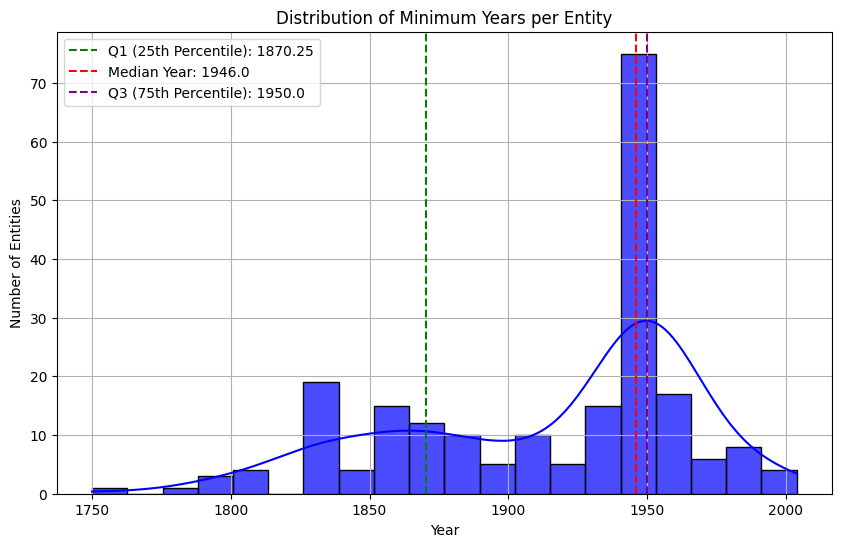

Median of minimum years across all entities: 1946.0
Q1 (25th percentile) of minimum years across all entities: 1870.25
Q3 (75th percentile) of minimum years across all entities: 1950.0


In [167]:
# EXPERIMENTING WITH THRESHOLDS PT2
# When we keep only the data after 2004, we loose too much information
# Looking at Q1, Q2, Q3 values instead?

q1_year = min_year_per_entity.quantile(0.25)
q3_year = min_year_per_entity.quantile(0.75)

plt.figure(figsize=(10, 6))
sns.histplot(min_year_per_entity, bins=20, kde=True, color='blue', alpha=0.7)

median_year = min_year_per_entity.median()
plt.axvline(q1_year, color='green', linestyle='--', label=f'Q1 (25th Percentile): {q1_year}')
plt.axvline(median_year, color='red', linestyle='--', label=f'Median Year: {median_year}')
plt.axvline(q3_year, color='purple', linestyle='--', label=f'Q3 (75th Percentile): {q3_year}')

plt.title('Distribution of Minimum Years per Entity')
plt.xlabel('Year')
plt.ylabel('Number of Entities')
plt.legend()
plt.grid(True)
plt.show()

print(f"Median of minimum years across all entities: {median_year}")
print(f"Q1 (25th percentile) of minimum years across all entities: {q1_year}")
print(f"Q3 (75th percentile) of minimum years across all entities: {q3_year}")

In [168]:
filtered_df = filtered_df[filtered_df['Year'] >= q1_year]

In [170]:
# CALCULATING TOTAL EMISSION PER COUNTRY ACROSS ALL YEARS

country_emissions = filtered_df.groupby('Entity')['emissions_total'].sum().sort_values(ascending=False)

In [109]:
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [171]:
import matplotlib.pyplot as plt

def plot_data(data, title="Total Emissions Per Country"):
    """
    Helper function to plot country's emission data
    """
    
    plt.figure(figsize=(25, 6))
    data.plot(kind='bar', color='skyblue', edgecolor='black')

    plt.title(title, fontsize=16)
    plt.xlabel('Country', fontsize=14)
    plt.ylabel('Total Emissions', fontsize=14)
    plt.xticks(rotation=90, fontsize=10, ha='center')

    plt.tight_layout()
    plt.show()

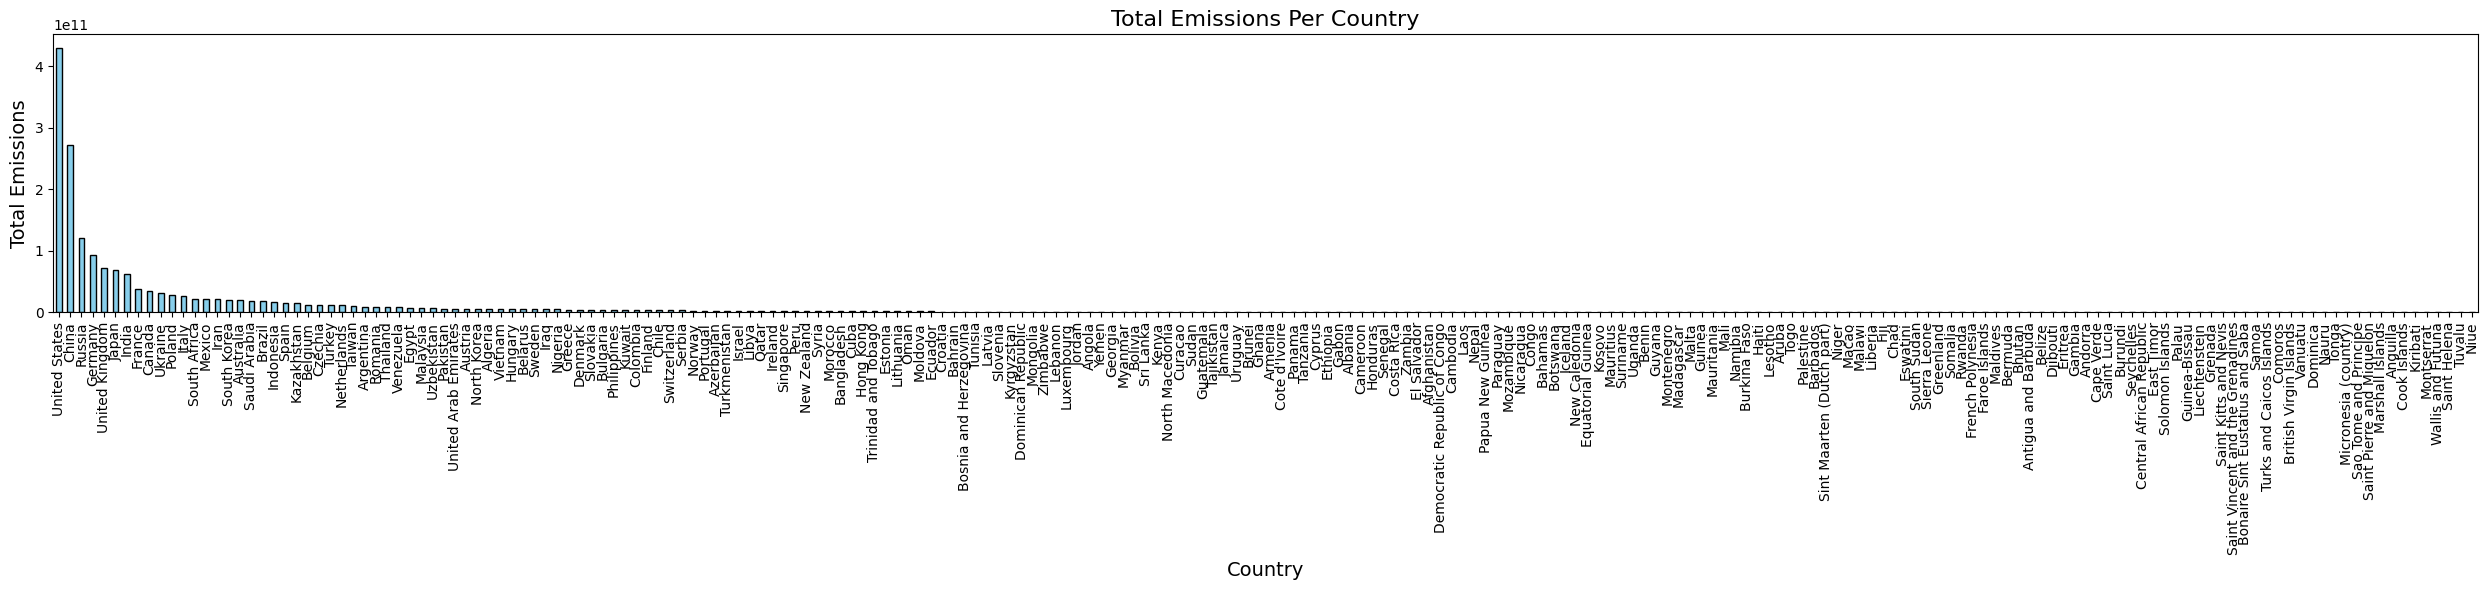

In [172]:
plot_data(country_emissions)

In [181]:
from typing import Tuple
import pandas as pd

def get_davids_and_goliaths(k: int = 10) -> Tuple[pd.DataFrame, pd.DataFrame]:
    return country_emissions.tail(k), country_emissions.head(k)

davids, goliaths = get_davids_and_goliaths()


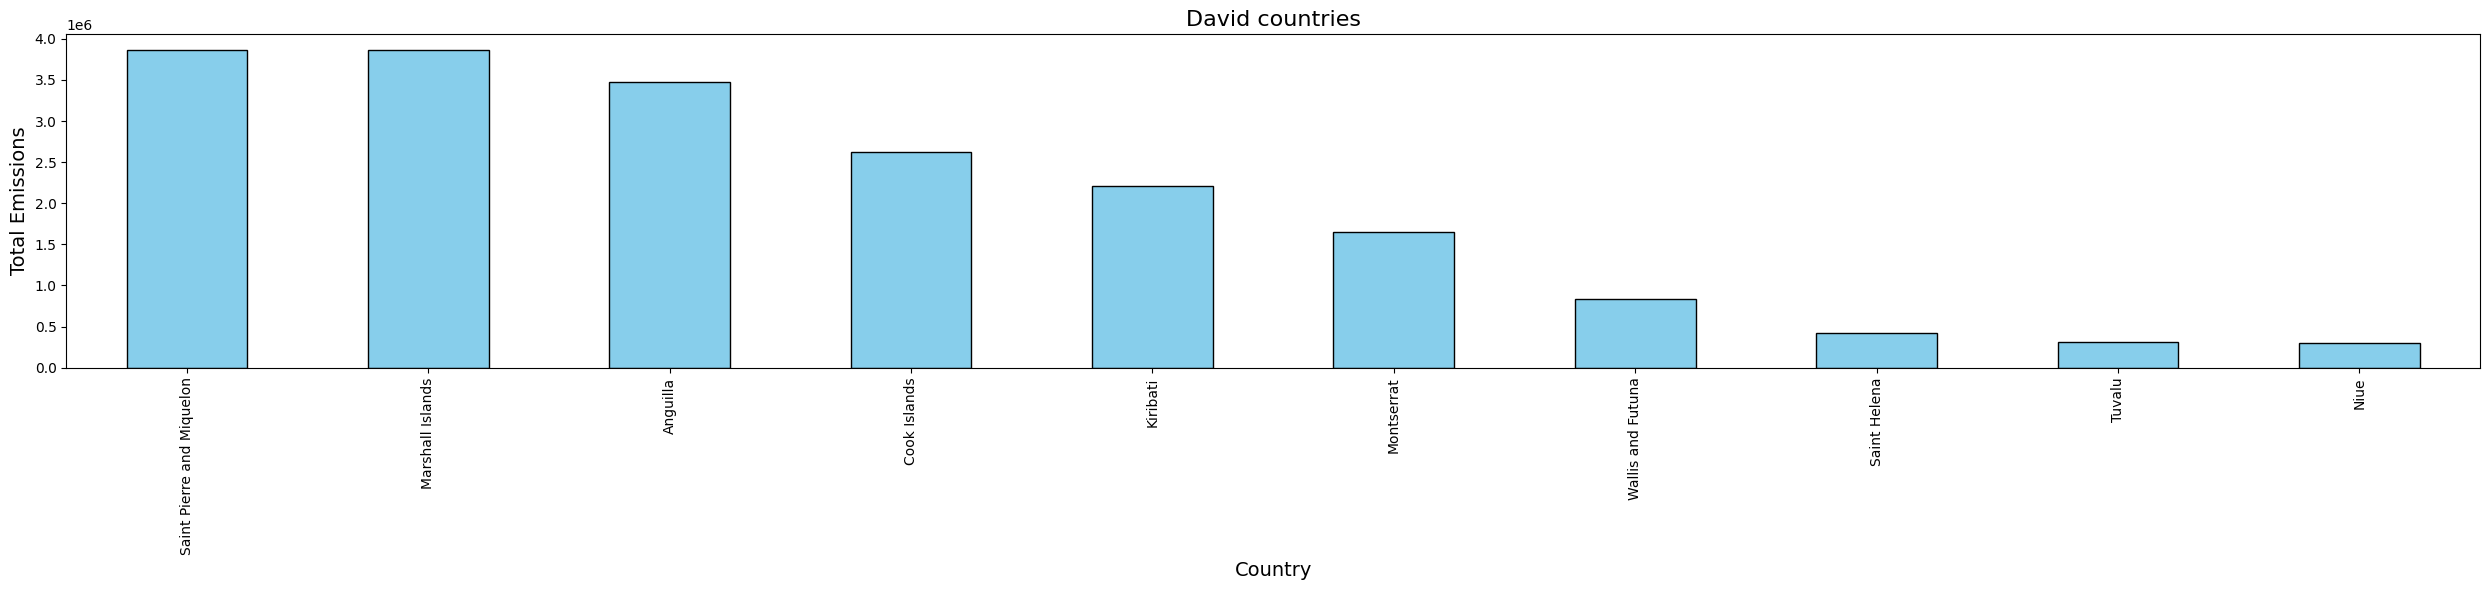

In [182]:
plot_data(davids, "David countries")

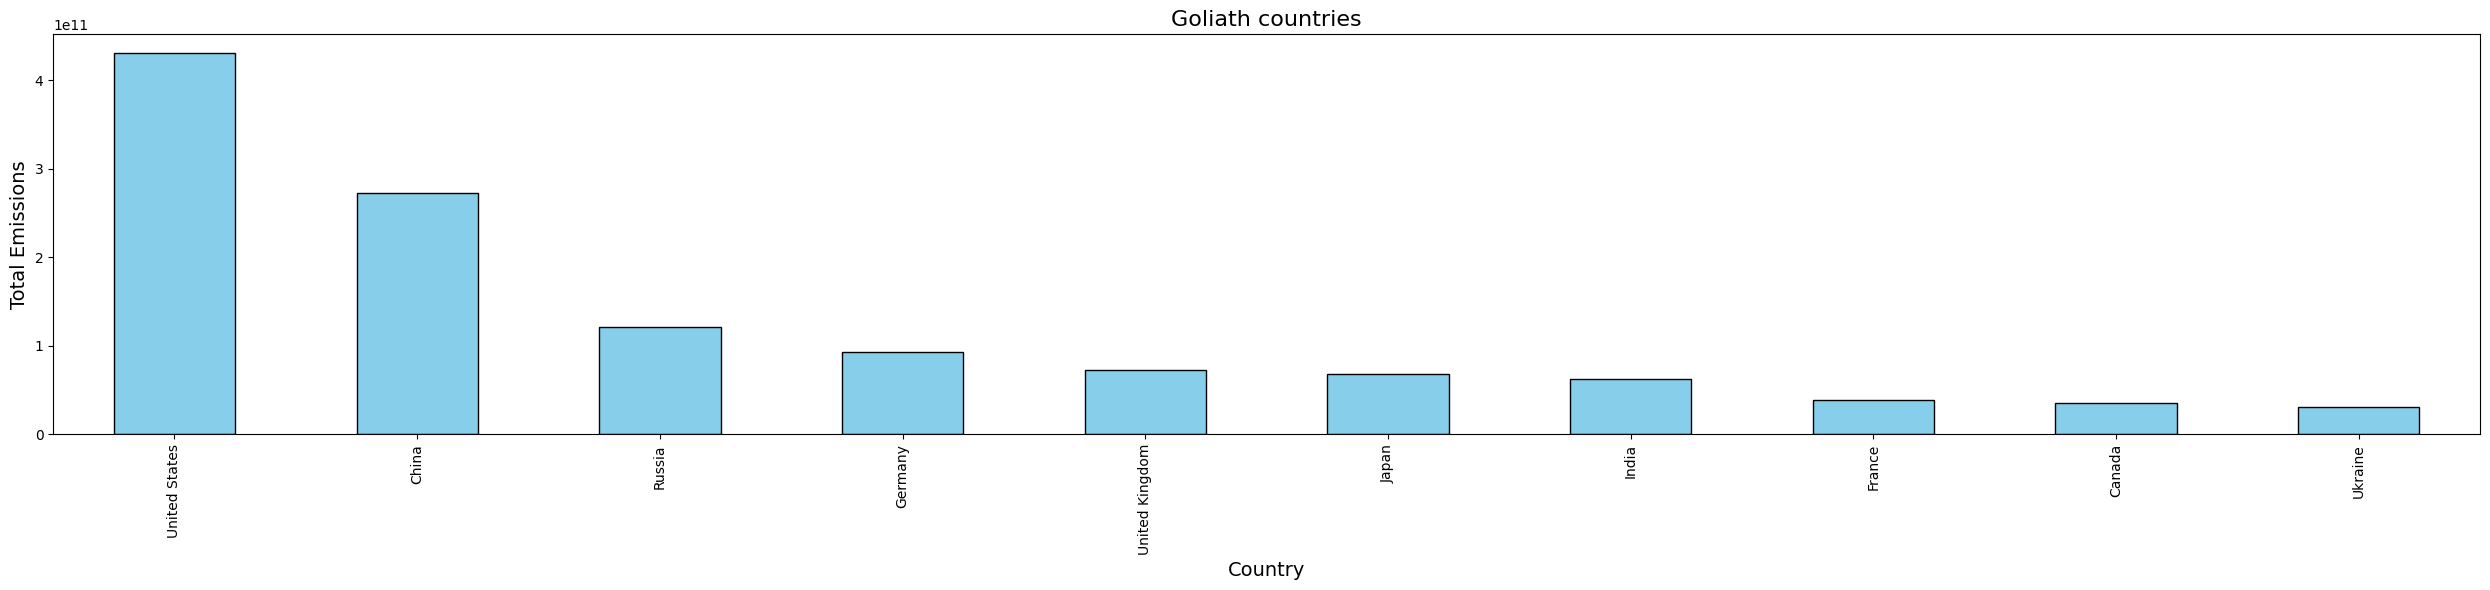

In [183]:
plot_data(goliaths, "Goliath countries")

In [179]:
# Still, we see that not all countries have the same number of rows after all the filtering we did
# The questions is if we want to loose on data or perfect statistic accuracy according to data volume per country

print(len(filtered_df[filtered_df["Entity"] == "Niue"]))
print(len(filtered_df[filtered_df["Entity"] == "China"]))

54
117


In [184]:
# TRYING THE 'AVERAGE' APPROACH
# Aside from filtering out data before a year, we can also try averaging the total emission across the years

filtered_df = get_filtered_data()
country_emissions = filtered_df.groupby('Entity')['emissions_total'].mean().sort_values(ascending=False)

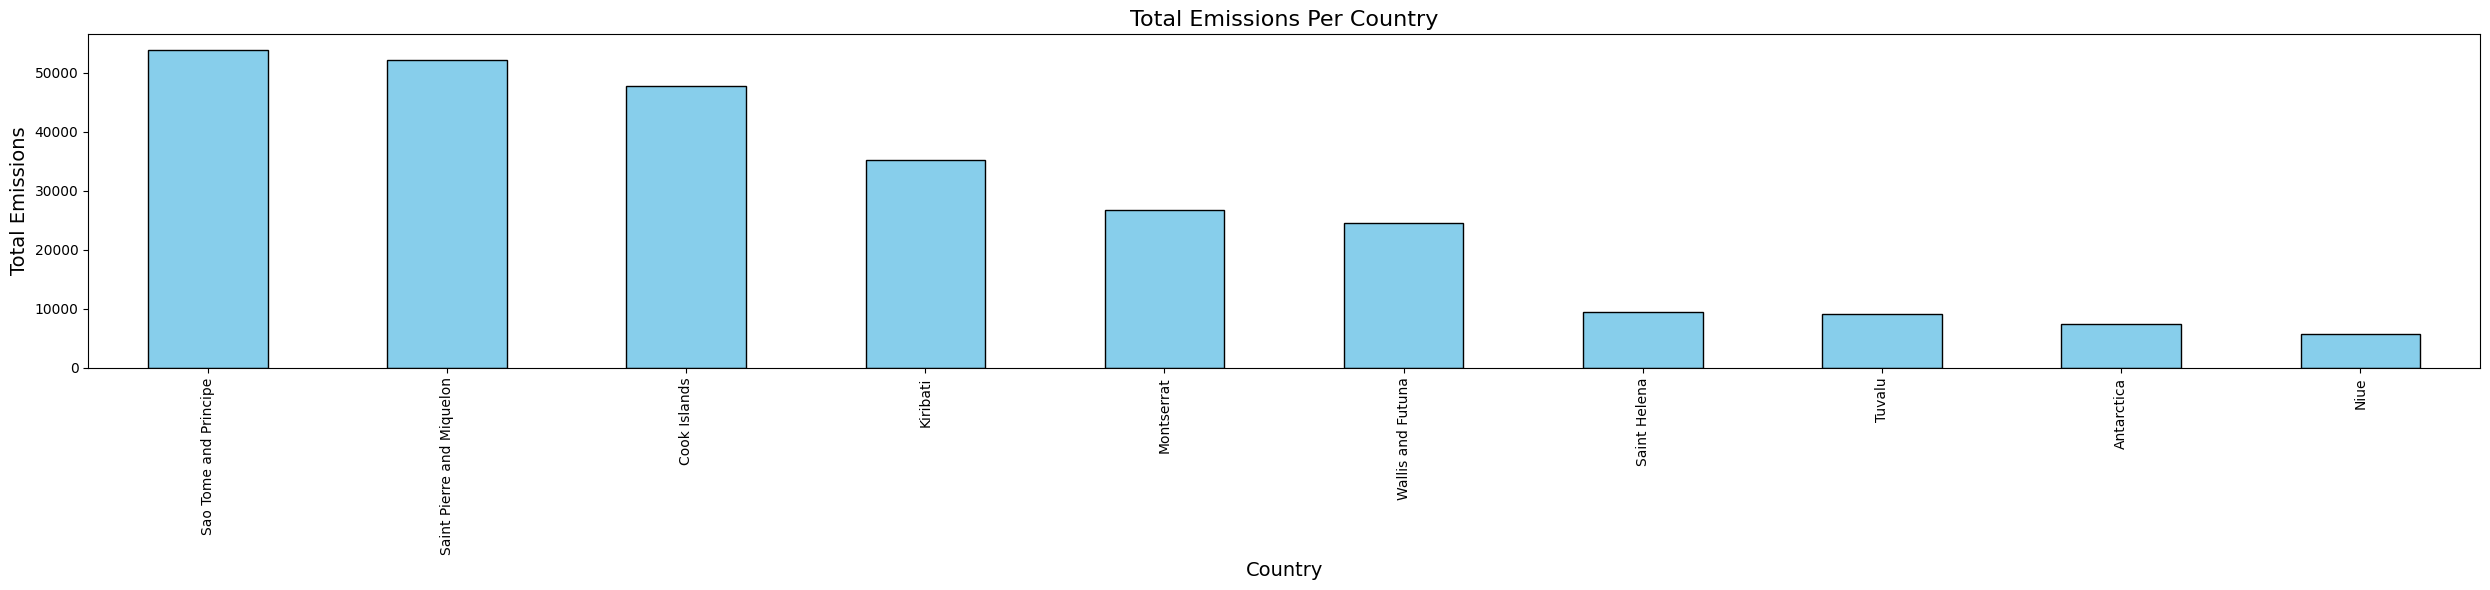

In [185]:
davids, goliaths = get_davids_and_goliaths()
plot_data(davids)

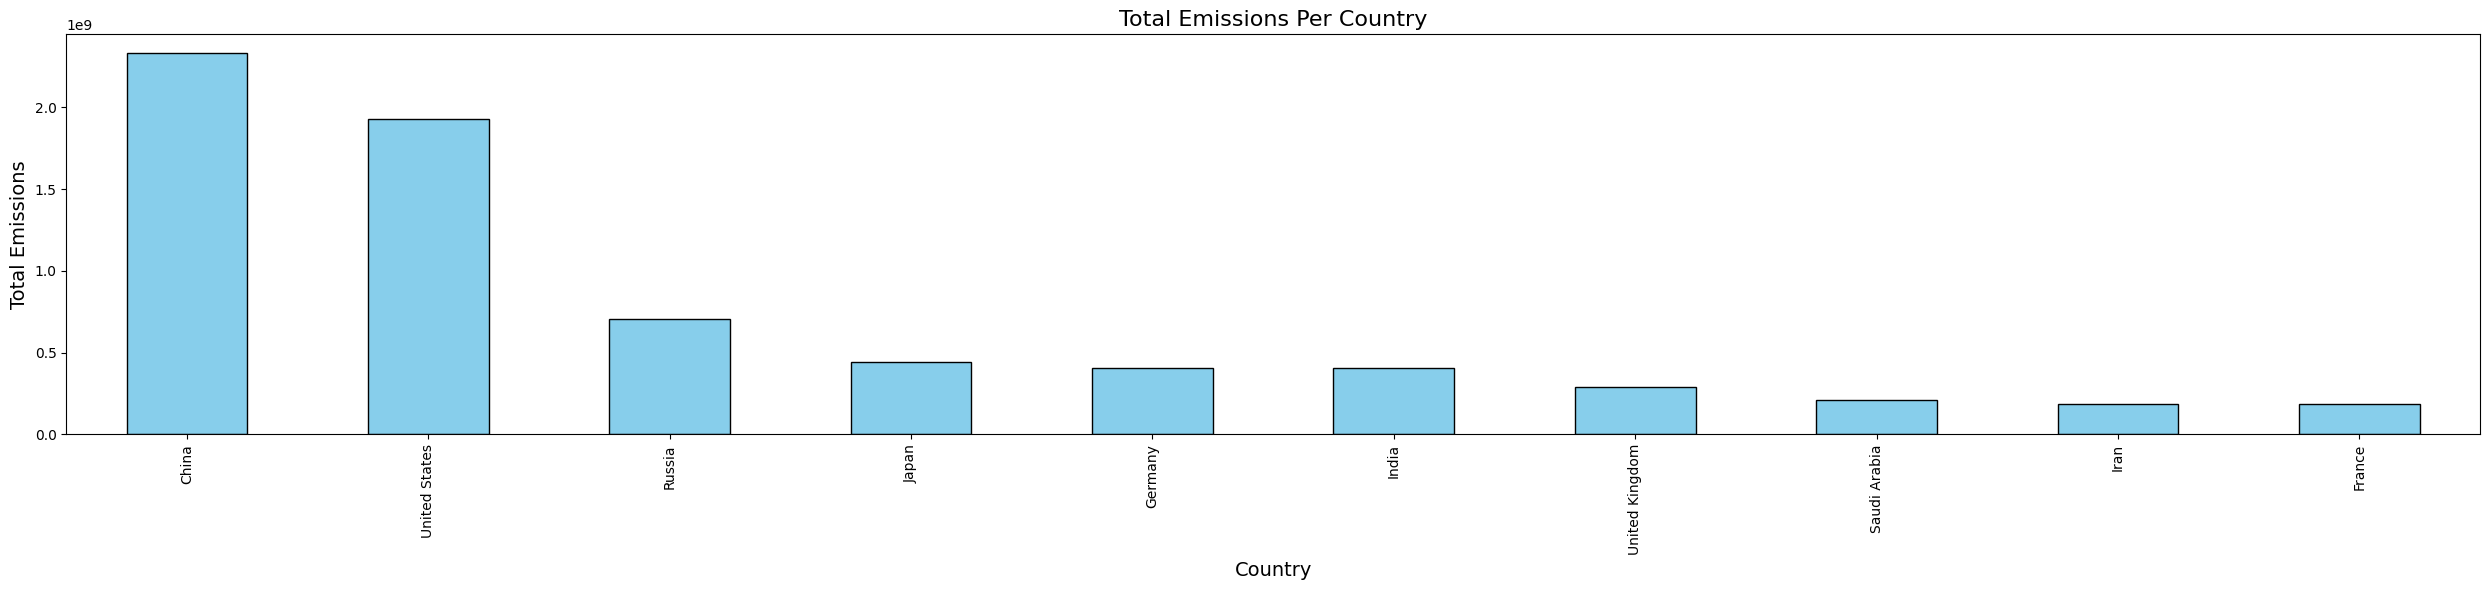

In [186]:
plot_data(goliaths)

In [ ]:
# Conclusion: Looking at the top k elements, the differences based on filtering after a year and averaging are minor
# Chosen approach depends on personal preference and reasoning